# Synthetic data

This notebook generates synthetic data.

- Synthetic users (ideal points) sampled from Gaussian clusters.
- Binary statements defined by pairs of points with a perpendicular decision boundary.
- Likert-style statements represented as ordered points along a gradient.

All generated CSVs are saved into the `../data/` directory.

Required packages: `numpy`, `pandas`, `scipy`, `matplotlib`. 

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy.random import Generator, PCG64
rng = Generator(PCG64(seed=0))

## Users

Generate a set of synthetic users (ideal points) by sampling from several Gaussian clusters.
These user coordinates are saved to `../data/synthetic_users.csv` and plotted below.

In [15]:
# Means and covariance matrices
means = [[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5], [0, 0]]
covs  = [np.diag([0.025, 0.025]) for _ in means]

# Number of samples per class
N = 50

# Generate samples for each Gaussian class
users_list = []
for i, (mean, cov) in enumerate(zip(means, covs)):
    samples = multivariate_normal.rvs(mean=mean, cov=cov, size=N, random_state=rng.integers(1_000_000))
    df = pd.DataFrame(samples, columns=['x', 'y'])
    df['party'] = i
    users_list.append(df)

# Combine all classes into one DataFrame
users = pd.concat(users_list, ignore_index=True)
users.index.name = 'id'
users['color'] = 'C'+ users['party'].astype(str)
# Save to CSV
users.to_csv('../data/synthetic_users.csv', index=True, float_format="%.3f")
users

,x,y,party,color
id,,,,
0,-0.468133,-0.583416,0,C0
1,-0.244029,-0.432206,0,C0
2,-0.345982,-0.412084,0,C0
3,-0.513863,-0.558170,0,C0
4,-0.418988,-0.586317,0,C0
...,...,...,...,...
245,-0.154228,0.210119,4,C4
246,0.012340,-0.171272,4,C4
247,-0.079014,-0.067357,4,C4


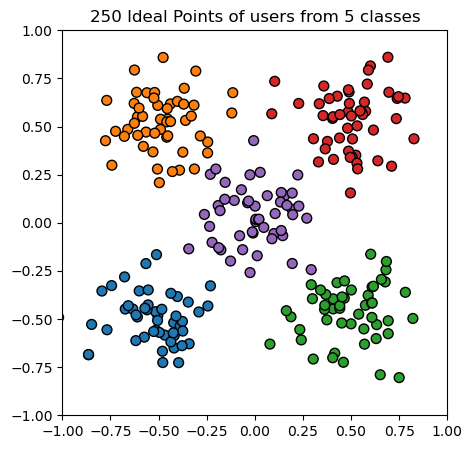

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(users.x, users.y, 
           color=users.color, 
           s=50,
           edgecolors='black')

ax.set(xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal',
       title=f'{N*5} Ideal Points of users from 5 classes'
      )

plt.show()

## Binary Statements

Create binary statements from pairs of points. For each statement we compute a perpendicular (cutting) line that defines the decision boundary between the two options.
The generated statements and user responses are saved to `../data/binary_statements.csv` and `../data/binary_reactions.csv`.

In [17]:
# Function to plot points and orthogonal line
def plot_points_and_orthogonal_line(row):
    x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
    plt.scatter([x1, x2], [y1, y2], c='C'+str(row.name))
    
    # Calculate Midpoint
    mx = (x1 + x2) / 2
    my = (y1 + y2) / 2
    
    # Rotate one point 90 degrees around the midpoint
    # Rotation Matrix for 90 degrees: [[0, -1], [1, 0]]
    rx = mx + (x1 - mx) * 0 - (y1 - my) * 1
    ry = my + (x1 - mx) * 1 + (y1 - my) * 0
    
    # Define the equation of the line passing through midpoint and rotated point
    if rx - mx == 0: # Avoid division by zero, line is vertical
        x_line = np.array([mx, mx])
        y_line = np.array([-1, 1])
    else:
        slope = (ry - my) / (rx - mx)
        intercept = my - slope * mx
        x_line = np.array([-1, 1])
        y_line = slope * x_line + intercept
    
    # Draw line between rotated point and midpoint
    plt.plot(x_line, y_line, c='C'+str(row.name), linestyle='--')
    
    return y_line

# Create a DataFrame with Q random statements
Q = 30
statements = rng.uniform(-1, 1, (Q, 4))
statements = pd.DataFrame(statements, columns=['x1', 'y1', 'x2', 'y2'], index=range(Q))
statements.head()

,x1,y1,x2,y2
0,-0.966945,0.626540,0.825511,0.213272
1,0.458993,0.087250,0.870145,0.631707
2,-0.994523,0.714809,-0.932829,0.459311
3,-0.648689,0.726358,0.082922,-0.400576
4,-0.154626,-0.943361,-0.751433,0.341249


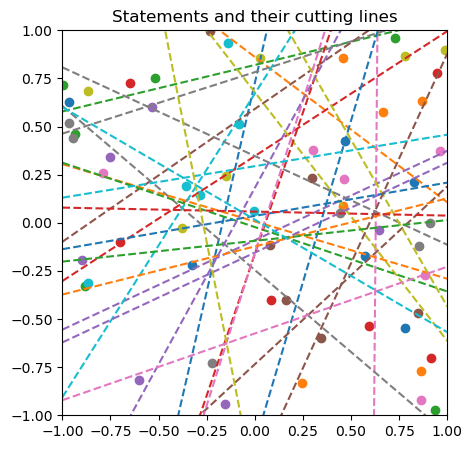

In [18]:
# Plotting
fig, ax = plt.subplots(figsize=(5,5))

# Apply the function to each row of the DataFrame
statements['feature'] = "Q" + (statements.index + 1).astype(str)
statements[['line1', 'line2']] = statements.apply(plot_points_and_orthogonal_line, axis=1, result_type='expand')
statements.to_csv('../data/binary_statements.csv', float_format="%.3f")

ax.set(title='Statements and their cutting lines',
       xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal'
      )

plt.show()

In [19]:
# Pairwise distances: users x statements
A = cdist(users[['x','y']].values, statements[['x1','y1']].values, metric='euclidean')
A = pd.DataFrame(A, columns=statements.feature, index=users.index)

B = cdist(users[['x','y']].values, statements[['x2','y2']].values, metric='euclidean')
B = pd.DataFrame(B, columns=statements.feature, index=users.index)

# Generate reactions: 1 if closer to 'x2,y2', 0 otherwise
reactions = (A > B).astype(int)
reactions.index.name = 'id'
reactions.to_csv('../data/binary_reactions.csv', index=True, float_format="%.3f")

reactions

feature,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
2,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,0
3,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,0
4,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,1,1,1,0,1,1,0,0,...,1,1,1,1,1,1,1,0,0,1
246,1,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
247,1,0,1,1,1,0,1,1,0,0,...,0,1,1,0,0,1,1,0,0,0


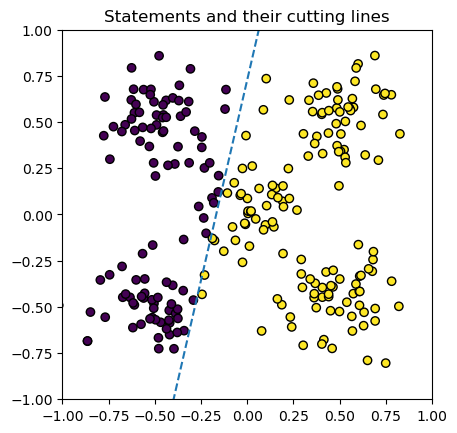

In [20]:
def plot_feature(i):
    fig, ax = plt.subplots()
    x_min, x_max = -1,1
    y_min, y_max = -1,1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    ax.plot([-1,1], statements.iloc[i,5:7] , c='C'+str(i), linestyle='--')

    # Plot the data points
    ax.scatter(users.iloc[:, 0], users.iloc[:, 1], c=reactions.iloc[:,i], edgecolors='k')

    ax.set(title='Statements and their cutting lines',
        xlim=[-1,1],
        ylim=[-1,1],
        aspect='equal'
        )
    
plot_feature(0)

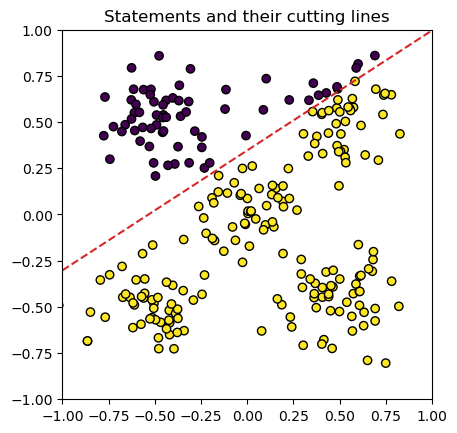

In [21]:
plot_feature(3)

## Likert Scales

Generate multi-option (Likert-style) statements by interpolating between two anchor points to form an ordered set of options.
Save the statement definitions to `../data/likert_statements.csv` and the simulated user answers to `../data/likert_reactions.csv`.

In [22]:
# Create a DataFrame with N random anchor pairs and interpolate intermediate points
N = 40
answers = rng.uniform(-1, 1, (N, 4))
answers = pd.DataFrame(answers, columns=['x1', 'y1', 'x4', 'y4'])

f = lambda row: np.hstack([k*row.loc[['x4','y4']].values+(1-k)*row.loc[['x1','y1']].values for k in [0.33, 0.66]])
answers[['x2','y2','x3', 'y3']] = answers.apply(f, axis=1, result_type='expand')
answers['feature'] = "Q" + (answers.index + 1).astype(str)
answers.to_csv('../data/likert_statements.csv', float_format="%.3f")

answers = answers.sort_index(axis=1)
answers.head()

,feature,x1,x2,x3,x4,y1,y2,y3,y4
0,Q1,0.124464,-0.087103,-0.298670,-0.516649,-0.482271,-0.066963,0.348344,0.776237
1,Q2,-0.548261,-0.507037,-0.465812,-0.423338,-0.750891,-0.446255,-0.141620,0.172246
2,Q3,0.108181,0.112395,0.116610,0.120952,0.619422,0.275370,-0.068681,-0.423158
3,Q4,-0.174207,-0.033225,0.107758,0.253013,0.636242,0.729273,0.822305,0.918155
4,Q5,-0.261191,-0.113008,0.035175,0.187848,0.105223,0.300372,0.495520,0.696582


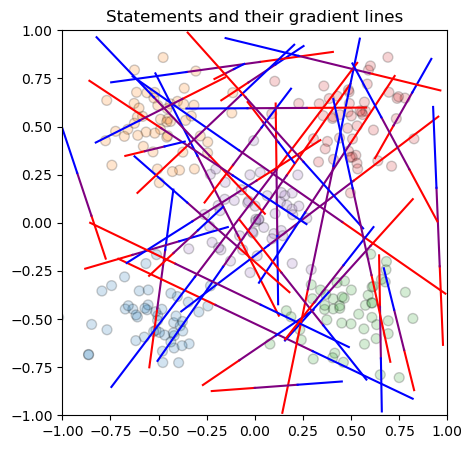

In [23]:
# Define the colormap
colormap = mpl.colors.LinearSegmentedColormap.from_list("coolwarm", ["red", "blue"])

def plot_decision_gradient_line(row):
    row = row.drop('feature')
    # Reshape the object's data into 4 points with x,y coordinates
    points = row.values.reshape(2, 4).T

    # Plot lines between the points with color changing from red to blue
    for i in range(3):  # since there are 4 points, there will be 3 segments between them
        plt.plot(points[i:i+2, 0], points[i:i+2, 1], color=colormap(i/2.))

fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(users.x, users.y, 
           color='C'+users.party.astype(str), 
           s=50,
           edgecolors='black',
           alpha=0.2)

answers.apply(plot_decision_gradient_line, axis=1)

ax.set(title='Statements and their gradient lines',
       xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal'
      )

plt.show()

In [24]:
options = []

for i in range(4):
    # Select the i-th answer column and the corresponding y-column (assumes y-columns are offset by 4)
    answer_points = answers.iloc[:, [i+1, i+5]].values  # shape: (n_answers, 2)
    # Compute distances: users x answer_points
    dists = cdist(users[['x','y']].values, answer_points, metric='euclidean')
    options.append(dists)

# Stack distances: shape (4, n_users, n_answers)
options = np.array(options)

# Choose the index of the minimum distance along the first axis (closest option)
R3 = options.argmin(axis=0).astype(int)  # shape: (n_users, n_answers)

# Convert to DataFrame
R3 = pd.DataFrame(R3, columns=answers.feature, index=users.index)
R3.to_csv('../data/likert_reactions.csv', index=True, float_format="%.3f")
R3

feature,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,3,0,0,1,1,0,3,1,...,3,3,2,3,3,0,0,1,3,0
1,0,1,3,0,0,1,1,1,2,2,...,3,3,2,2,3,1,0,1,2,1
2,1,1,3,0,0,1,1,1,2,2,...,3,3,2,3,3,0,0,1,3,1
3,0,1,3,0,0,1,1,0,3,1,...,3,3,2,3,3,0,0,1,3,1
4,0,1,3,0,0,1,1,0,3,1,...,3,3,2,3,3,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2,3,1,0,1,1,0,3,2,3,...,2,3,2,1,2,3,1,2,3,2
246,1,2,2,0,0,1,0,3,1,3,...,3,3,2,1,2,3,0,1,2,1
247,1,2,2,0,0,1,0,3,2,3,...,3,3,2,1,2,3,0,2,2,1


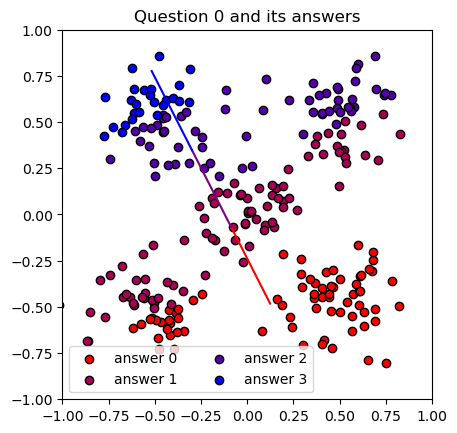

In [25]:
def plot_answer(i):
    fig, ax = plt.subplots()
    x_min, x_max = -1,1
    y_min, y_max = -1,1
    
    data = R3.iloc[:,i]
    
    # Plot the data points
    for c in range(4):
        mask = data == c
        ax.scatter(users.loc[mask, 'x'], users.loc[mask, 'y'], color=colormap(c/3.), edgecolors='k', label='answer '+str(c))
   
    plot_decision_gradient_line(answers.iloc[i,:])
    
    ax.set(title=f'Question {i} and its answers',
       xlim=[-1,1],
       ylim=[-1,1],
       aspect='equal'
      )
    
    ax.legend(ncol=2)
    
plot_answer(0)

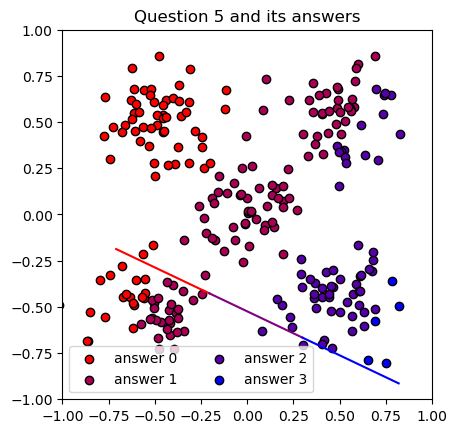

In [26]:
plot_answer(5)